In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from models.building.building import BuildingModel
from models.heat_pump.heat_pump import HeatPumpEventBased, HeatPumpWControlEventBased
from models.weather.weather import SynproWeather
from models.demand.loadprofilegenerator import Household
from models.smart_meter.smart_meter import SmartMeter

from simplec_examples.models.hyst_controller import HystController 
from simplec import Simulation

In [5]:
sim = Simulation()

# Weather
weather    = SynproWeather(name='weather')
sim.add_model(weather,    watch_values=['T_amb', 'I_dir', 'I_dif'])

###########
# Building
###########
# Building Envelope
building   = BuildingModel(name='building_envelope', count_of_dot_Q_int=2)
sim.add_model(building,   watch_values=['T_building'])
sim.connect(weather, building, 'T_amb', 'I_dir', 'I_dif', 'I_s', 'I_w', 'I_n', 'I_e')
sim.connect_constant(0.0, building, 'dot_Q_cool', )

# Heat Pump
heatpump   = HeatPumpWControlEventBased(
    'heatpump',
    eta=0.4,
    dot_Q_hp_nom=15000,
    P_el_max=4000,
    P_el_min=1000
    )
sim.add_model(heatpump,   watch_values=['P_el', 'dot_Q_hp'])
sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(weather, heatpump, ('T_amb', 'T_source'))
sim.connect(building, heatpump, ('T_building', 'T_sink'), time_shifted=True, init_values={'T_building': 21})

# HP Controller
controller = HystController(
    'controller',
    hyst=2.
    )
sim.add_model(controller)
sim.connect(controller, heatpump, ('state', 'state'), triggers=['state'])
sim.connect(building, controller, ('T_building', 'T_is'), time_shifted=True, init_values={'T_building': 21})

##############
# Appartments
##############

###############
# Appartment 1
###############
appartment1 = Household(
    name='appartment_1',
    lpg_dir='data/loadprofilegenerator/CHR41 Family with 3 children, both at work/Results'
    )
sim.add_model(appartment1, 
              watch_values=['P_el', 'dot_m_ww', 'dot_Q_gain_int']
              )
sim.connect(appartment1, building, ('dot_Q_gain_int', 'dot_Q_int_0'))

# Smart meter
smartmeter_apprtmnt1 = SmartMeter(name='smartmeter_appartment_1', n_loads=1)
sim.add_model(smartmeter_apprtmnt1)
sim.connect(appartment1, smartmeter_apprtmnt1, ('P_el', 'P_0'))

###############
# Appartment 2   # TODO: create and change profile
###############
appartment2 = Household(
    name='appartment_2',
    lpg_dir='data/loadprofilegenerator/CHR41 Family with 3 children, both at work/Results'
    )
sim.add_model(appartment2, 
              watch_values=['P_el', 'dot_m_ww', 'dot_Q_gain_int']
              )
sim.connect(appartment2, building, ('dot_Q_gain_int', 'dot_Q_int_1'))

# Smart meter
smartmeter_apprtmnt2 = SmartMeter(name='smartmeter_appartment_2', n_loads=1)
sim.add_model(smartmeter_apprtmnt2)
sim.connect(appartment2, smartmeter_apprtmnt2, ('P_el', 'P_0'))


# Appartment 3


# E-Grid

# Grid Operator

# Battery storage

In [6]:
times = pd.date_range('2021-01-01 00:00:00', '2021-01-03 00:00:00', freq='1min', tz='Europe/Berlin')  # 'UTC+01:00')
sim.run(times)

Progress: 100%|██████████| 2881/2881 [00:14<00:00, 197.36Steps/s]


In [7]:
# Attempt to convert df to numeric
df = sim.df
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col])
df = df.ffill()
df.head()

C:\Users\seva\AppData\Local\Temp\ipykernel_12048\3468714922.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col])


model                       weather             building_envelope  \
i/o                         outputs                       outputs   
attribute                     T_amb I_dir I_dif        T_building   
2021-01-01 00:00:00+01:00  0.800000   0.0   0.0         19.989936   
2021-01-01 00:01:00+01:00  0.811667   0.0   0.0         19.998968   
2021-01-01 00:02:00+01:00  0.823333   0.0   0.0         20.008002   
2021-01-01 00:03:00+01:00  0.835000   0.0   0.0         20.017037   
2021-01-01 00:04:00+01:00  0.846667   0.0   0.0         20.026074   

model                         heatpump          controller          \
i/o                            outputs              inputs outputs   
attribute                         P_el dot_Q_hp       T_is   state   
2021-01-01 00:00:00+01:00     0.000000      0.0  21.000000     off   
2021-01-01 00:01:00+01:00  2453.384948  15000.0  19.989936      on   
2021-01-01 00:02:00+01:00  2452.972305  15000.0  19.998968      on   
2021-01-01 00:03:00+01:00  2452.559903  15000.0  20.008002      on   
2021-01-01 00:04:00+01:00  2452.147741  15000.0  20.017037      on   

model                     appartment_1                         appartment_2  \
i/o                            outputs                              outputs   
attribute                         P_el dot_m_ww dot_Q_gain_int         P_el   
2021-01-01 00:00:00+01:00    49.168963      0.0      48.585394    49.168963   
2021-01-01 00:01:00+01:00    49.168963      0.0      48.585394    49.168963   
2021-01-01 00:02:00+01:00    49.168963      0.0      48.585394    49.168963   
2021-01-01 00:03:00+01:00    49.168963      0.0      48.585394    49.168963   
2021-01-01 00:04:00+01:00    49.168963      0.0      48.585394    49.168963   

model                                              
i/o                                                
attribute                 dot_m_ww dot_Q_gain_int  
2021-01-01 00:00:00+01:00      0.0      48.585394  
2021-01-01 00:01:00+01:00      0.0      48.585394  
2021-01-01 00:02:00+01:00      0.0      48.585394  
2021-01-01 00:03:00+01:00      0.0      48.585394  
2021-01-01 00:04:00+01:00      0.0      48.585394

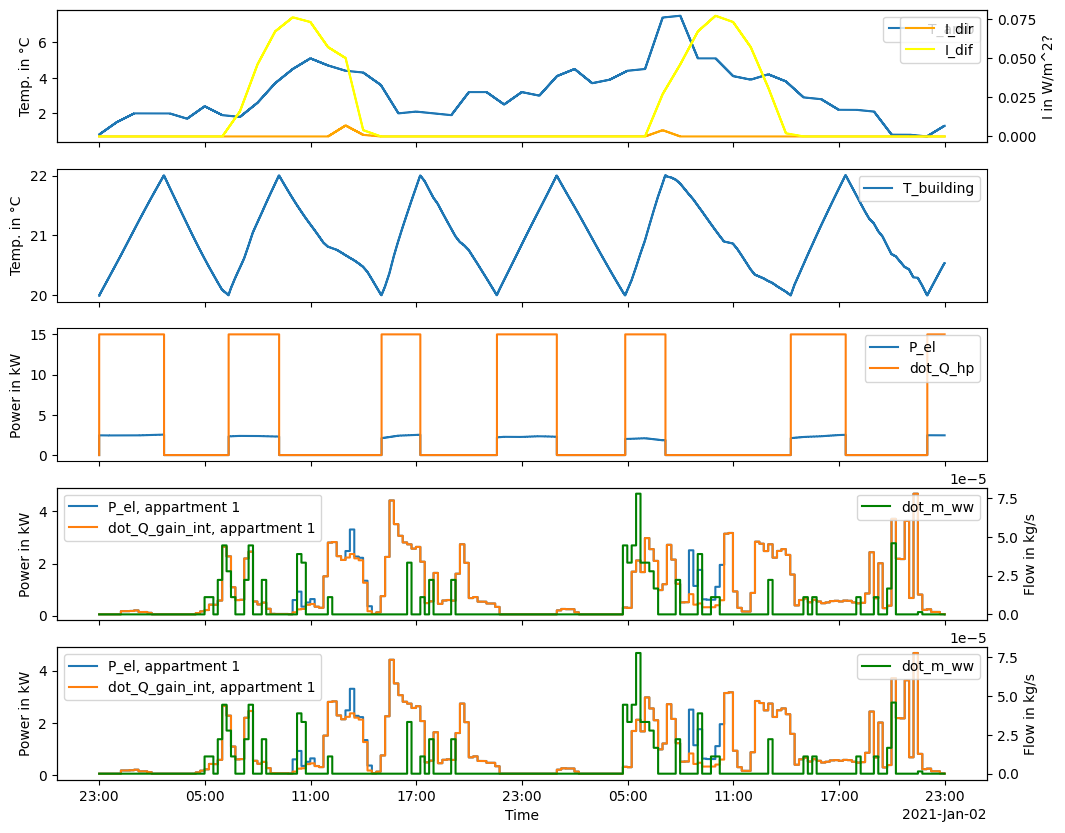

In [12]:
dtindex = df.index 

fig, axs = plt.subplots(5, sharex=True, figsize=(12, 10))

# Weather
ax = axs[0]
ax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'T_amb')], label='T_amb', drawstyle='steps')
ax.legend()
ax.set_ylabel('Temp. in °C')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'I_dir')]/1000, label='I_dir', drawstyle='steps', color='orange')
tax.plot(dtindex, df.loc[:, ('weather', 'outputs', 'I_dif')]/1000, label='I_dif', drawstyle='steps', color='yellow')
tax.legend()
tax.set_ylabel('I in W/m^2?')

# Building Temperature
ax = axs[1]
ax.plot(dtindex, df.loc[:, ('building_envelope', 'outputs', 'T_building')], label='T_building', drawstyle='steps')
ax.legend()
ax.set_ylabel('Temp. in °C')

# Heat Pump
ax = axs[2]
ax.plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp', drawstyle='steps')
ax.legend()
ax.set_ylabel('Power in kW')

# Appartment 1
ax = axs[3]
ax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'P_el')]/1000, label='P_el, appartment 1', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'dot_Q_gain_int')]/1000, label='dot_Q_gain_int, appartment 1', drawstyle='steps')
ax.legend()
ax.set_ylabel('Power in kW')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('appartment_1', 'outputs', 'dot_m_ww')]/1000, label='dot_m_ww', drawstyle='steps', color='green')
tax.legend()
tax.set_ylabel('Flow in kg/s')

# Appartment 2
ax = axs[4]
ax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'P_el')]/1000, label='P_el, appartment 1', drawstyle='steps')
ax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'dot_Q_gain_int')]/1000, label='dot_Q_gain_int, appartment 1', drawstyle='steps')
ax.legend()
ax.set_ylabel('Power in kW')

tax = ax.twinx()
tax.plot(dtindex, df.loc[:, ('appartment_2', 'outputs', 'dot_m_ww')]/1000, label='dot_m_ww', drawstyle='steps', color='green')
tax.legend()
tax.set_ylabel('Flow in kg/s')

axs[-1].set_xlabel('Time')
axs[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[-1].xaxis.get_major_locator(),))